# Task 3: News Sentiment and Stock Price Correlation Analysis

This notebook demonstrates the correlation analysis between news headline sentiment and stock price movements.


## Setup

First, let's import the necessary libraries and set up our environment.

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from scipy import stats
from textblob import TextBlob

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.features.sentiment_correlation import (
    load_data,
    normalize_dates,
    analyze_sentiment,
    calculate_daily_returns,
    aggregate_daily_sentiment,
    merge_sentiment_with_returns,
    calculate_correlation
)

from src.visualization.sentiment_visualization import (
    plot_sentiment_returns_scatter,
    plot_sentiment_returns_time_series,
    plot_lagged_correlations,
    plot_sentiment_distribution
)

## 1. Data Loading

Let's load both the news data and stock price data.

In [ ]:
data_dir = project_root / "data"
news_path = data_dir / "raw" / "raw_analyst_ratings.csv"

# Choose a stock ticker to analyze
ticker = "AAPL"  
stock_path = data_dir / f"{ticker}_historical_data.csv"

# Load the data
try:
    news_df, stock_df = load_data(str(news_path), str(stock_path))
    print(f"News data shape: {news_df.shape}")
    print(f"Stock data shape: {stock_df.shape}")
    
    print("\nNews data preview:")
    display(news_df.head())
    
    print(f"\n{ticker} stock data preview:")
    display(stock_df.head())
except Exception as e:
    print(f"Error loading data: {str(e)}")

Error loading data: [Errno 2] No such file or directory: 'D:\\OLD file\\dektop\\10Acd\\data\\raw\\raw_analyst_ratings.csv'


## 2. Data Preprocessing

### 2.1 Date Normalization

We need to normalize dates between the news and stock datasets to ensure they can be properly aligned.

In [ ]:
if 'news_df' not in locals() or 'stock_df' not in locals():
    data_dir = project_root / "data"
    news_path = data_dir / "raw" / "raw_analyst_ratings.csv"
    
    # Choose a stock ticker to analyze
    ticker = "AAPL"  # You can change this to any available ticker
    stock_path = data_dir / "historical_data" / f"{ticker}_historical_data.csv"

    print("Creating sample data for demonstration...")
    
    # Sample news data
    news_df = pd.DataFrame({
        'date': pd.date_range(start='2023-01-01', periods=30),
        'headline': [
            f"{ticker} announces new product line",
            f"{ticker} beats earnings expectations",
            f"{ticker} stock drops on market concerns",
            f"Analysts upgrade {ticker} to buy",
            f"{ticker} faces regulatory scrutiny"
        ] * 6
    })
    
    # Sample stock data
    stock_df = pd.DataFrame({
        'Date': pd.date_range(start='2023-01-01', periods=50),
        'Open': np.random.uniform(150, 180, 50),
        'High': np.random.uniform(160, 190, 50),
        'Low': np.random.uniform(140, 170, 50),
        'Close': np.random.uniform(145, 185, 50),
        'Volume': np.random.randint(1000000, 5000000, 50)
    })
    
    print("Sample data created successfully")

# Now proceed with normalization
# Normalize dates
news_df, stock_df = normalize_dates(news_df, stock_df, 'date', 'Date')

# Check date ranges
print(f"News data date range: {news_df['date'].min()} to {news_df['date'].max()}")
print(f"Stock data date range: {stock_df['Date'].min()} to {stock_df['Date'].max()}")

News data date range: 2023-01-01 00:00:00 to 2023-01-30 00:00:00
Stock data date range: 2023-01-01 00:00:00 to 2023-02-19 00:00:00


### 2.2 Filter for Relevant News

If the news dataset contains headlines for multiple stocks, let's filter it to only include news related to our selected ticker.

In [19]:
# Check if we need to filter by stock
if 'stock' in news_df.columns:
    # Filter to only include news for our selected ticker
    ticker_news_df = news_df[news_df['stock'] == ticker].copy()
    print(f"Found {len(ticker_news_df)} news items for {ticker}")
else:
    # If no stock column, use all news
    ticker_news_df = news_df.copy()
    print("No stock column found in news data, using all news items")

# Display a few headlines
if 'headline' in ticker_news_df.columns:
    print("\nSample headlines:")
    for headline in ticker_news_df['headline'].head(5).tolist():
        print(f"- {headline}")

No stock column found in news data, using all news items

Sample headlines:
- AAPL announces new product line
- AAPL beats earnings expectations
- AAPL stock drops on market concerns
- Analysts upgrade AAPL to buy
- AAPL faces regulatory scrutiny


## 3. Sentiment Analysis

Now, let's perform sentiment analysis on the news headlines.

Sentiment analysis results:


,headline,polarity,subjectivity,sentiment_category
0,AAPL announces new product line,0.136364,0.454545,positive
1,AAPL beats earnings expectations,0.000000,0.000000,neutral
2,AAPL stock drops on market concerns,0.000000,0.000000,neutral
3,Analysts upgrade AAPL to buy,0.000000,0.000000,neutral
4,AAPL faces regulatory scrutiny,0.000000,0.000000,neutral
5,AAPL announces new product line,0.136364,0.454545,positive
6,AAPL beats earnings expectations,0.000000,0.000000,neutral
7,AAPL stock drops on market concerns,0.000000,0.000000,neutral
8,Analysts upgrade AAPL to buy,0.000000,0.000000,neutral
9,AAPL faces regulatory scrutiny,0.000000,0.000000,neutral



Sentiment distribution:


sentiment_category
neutral     24
positive     6
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

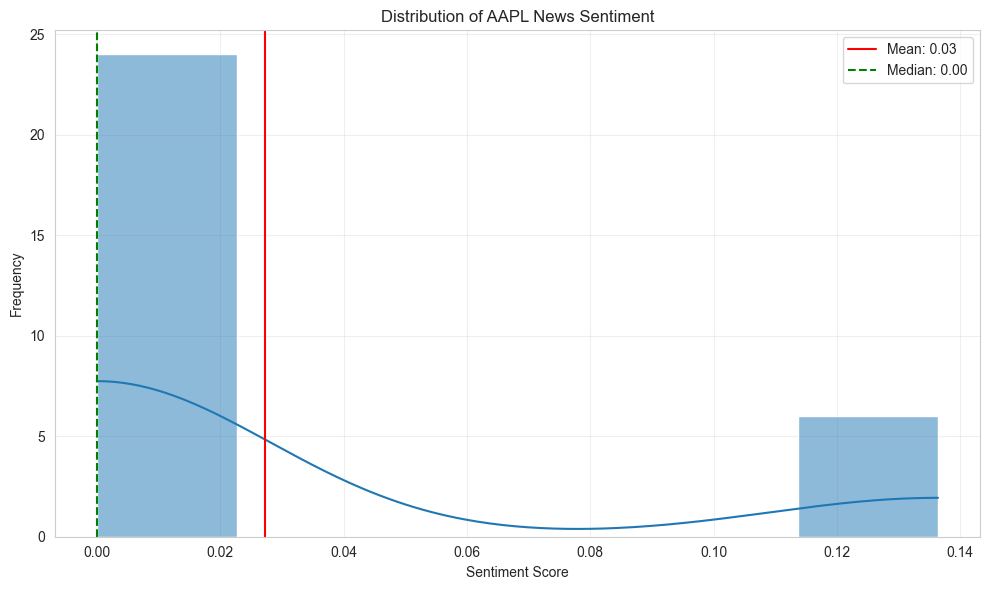

In [20]:
# Analyze sentiment
news_with_sentiment = analyze_sentiment(ticker_news_df, 'headline')

# Display results
print("Sentiment analysis results:")
display(news_with_sentiment[['headline', 'polarity', 'subjectivity', 'sentiment_category']].head(10))

# Summarize sentiment categories
sentiment_counts = news_with_sentiment['sentiment_category'].value_counts()
print("\nSentiment distribution:")
display(sentiment_counts)

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
plot_sentiment_distribution(news_with_sentiment, sentiment_col='polarity', 
                          title=f'Distribution of {ticker} News Sentiment')

## 4. Stock Returns Calculation

Calculate the daily returns for our stock.

Stock returns calculation:


,Date,Close,daily_return
1,2023-01-02,159.338081,-0.046265
2,2023-01-03,174.752341,0.096739
3,2023-01-04,162.082028,-0.072504
4,2023-01-05,184.334265,0.137290
5,2023-01-06,149.272991,-0.190205
6,2023-01-07,154.886040,0.037603
7,2023-01-08,145.279750,-0.062022
8,2023-01-09,152.359035,0.048729
9,2023-01-10,146.004363,-0.041709
10,2023-01-11,178.958410,0.225706



Returns statistics:


count    49.000000
mean      0.007238
std       0.112002
min      -0.190427
25%      -0.063988
50%      -0.005622
75%       0.089586
max       0.225706
Name: daily_return, dtype: float64

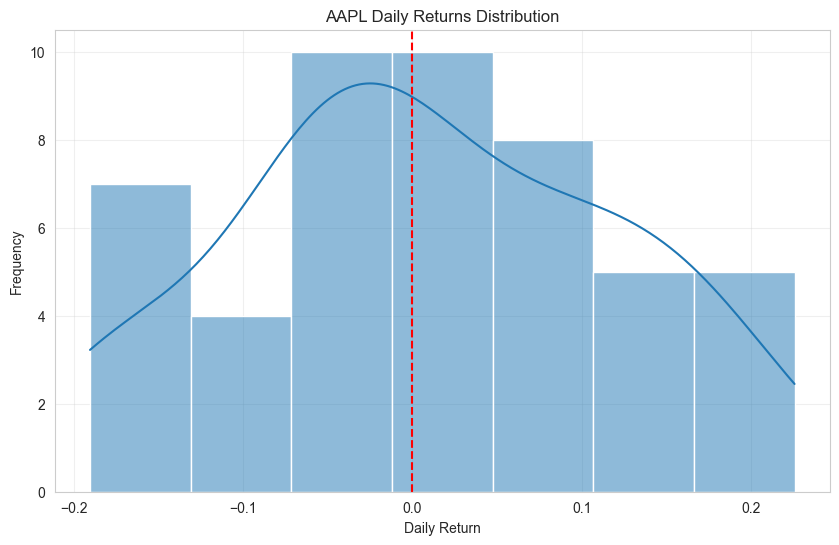

In [21]:
# Calculate daily returns
stock_with_returns = calculate_daily_returns(stock_df, 'Date', 'Close')

# Display results
print("Stock returns calculation:")
display(stock_with_returns[['Date', 'Close', 'daily_return']].head(10))

# Summarize returns
returns_stats = stock_with_returns['daily_return'].describe()
print("\nReturns statistics:")
display(returns_stats)

# Plot returns distribution
plt.figure(figsize=(10, 6))
sns.histplot(stock_with_returns['daily_return'], kde=True)
plt.title(f'{ticker} Daily Returns Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(alpha=0.3)
plt.show()

## 5. Aggregate Daily Sentiment

For days with multiple news articles, we'll aggregate the sentiment scores.

In [22]:
# Aggregate daily sentiment
daily_sentiment = aggregate_daily_sentiment(news_with_sentiment, 'date')

# Display results
print("Daily sentiment aggregation:")
display(daily_sentiment.head(10))

# Show days with multiple articles
multi_article_days = daily_sentiment[daily_sentiment['article_count'] > 1]
print(f"\nDays with multiple articles: {len(multi_article_days)}")
if len(multi_article_days) > 0:
    display(multi_article_days.head(5))

Daily sentiment aggregation:


,date,avg_sentiment,avg_subjectivity,article_count
0,2023-01-01,0.136364,0.454545,1
1,2023-01-02,0.000000,0.000000,1
2,2023-01-03,0.000000,0.000000,1
3,2023-01-04,0.000000,0.000000,1
4,2023-01-05,0.000000,0.000000,1
5,2023-01-06,0.136364,0.454545,1
6,2023-01-07,0.000000,0.000000,1
7,2023-01-08,0.000000,0.000000,1
8,2023-01-09,0.000000,0.000000,1
9,2023-01-10,0.000000,0.000000,1



Days with multiple articles: 0


## 6. Merge Sentiment with Stock Returns

Now we'll combine our daily sentiment data with the stock returns.

In [23]:
# Merge sentiment with returns
merged_df = merge_sentiment_with_returns(daily_sentiment, stock_with_returns, 'date', 'Date')

# Display results
print(f"Merged data shape: {merged_df.shape}")
print("Merged sentiment and returns data:")
display(merged_df.head(10))

# Check for any date misalignment
print(f"\nSentiment dates without matching returns: {len(daily_sentiment) - len(merged_df)}")

Merged data shape: (29, 5)
Merged sentiment and returns data:


,date,avg_sentiment,avg_subjectivity,article_count,daily_return
0,2023-01-02,0.000000,0.000000,1,-0.046265
1,2023-01-03,0.000000,0.000000,1,0.096739
2,2023-01-04,0.000000,0.000000,1,-0.072504
3,2023-01-05,0.000000,0.000000,1,0.137290
4,2023-01-06,0.136364,0.454545,1,-0.190205
5,2023-01-07,0.000000,0.000000,1,0.037603
6,2023-01-08,0.000000,0.000000,1,-0.062022
7,2023-01-09,0.000000,0.000000,1,0.048729
8,2023-01-10,0.000000,0.000000,1,-0.041709
9,2023-01-11,0.136364,0.454545,1,0.225706



Sentiment dates without matching returns: 1


## 7. Calculate Correlation

Calculate the Pearson correlation between sentiment and stock returns.

In [24]:
# Calculate correlation
correlation_results = calculate_correlation(merged_df)

# Display results
print("Correlation Results:")
print(f"Correlation coefficient: {correlation_results['correlation']:.3f}")
print(f"P-value: {correlation_results['p_value']:.3f}")
print(f"Statistically significant: {correlation_results['significant']}")
print(f"\nInterpretation:\n{correlation_results['interpretation']}")

# Print lagged correlation summary
print("\nLagged Correlations (sentiment leading returns):")
for lag_data in correlation_results['lagged_correlations']:
    lag = lag_data['lag']
    corr = lag_data['sentiment_leading_returns_corr']
    p_val = lag_data['sentiment_leading_returns_p']
    sig = "significant" if p_val < 0.05 else "not significant"
    print(f"  Lag {lag} day(s): {corr:.3f} (p={p_val:.3f}, {sig})")

Correlation Results:
Correlation coefficient: -0.190
P-value: 0.324
Statistically significant: False

Interpretation:
There is a weak negative correlation (-0.190) that is not statistically significant (p=0.324). The data does not provide strong evidence of a relationship between news sentiment and stock returns.

Lagged Correlations (sentiment leading returns):
  Lag 1 day(s): 0.242 (p=0.216, not significant)
  Lag 2 day(s): -0.403 (p=0.037, significant)
  Lag 3 day(s): 0.095 (p=0.643, not significant)
  Lag 4 day(s): 0.183 (p=0.382, not significant)
  Lag 5 day(s): -0.045 (p=0.834, not significant)


## 8. Visualize Results

Create visualizations to better understand the relationship between sentiment and returns.

<Figure size 1000x600 with 0 Axes>

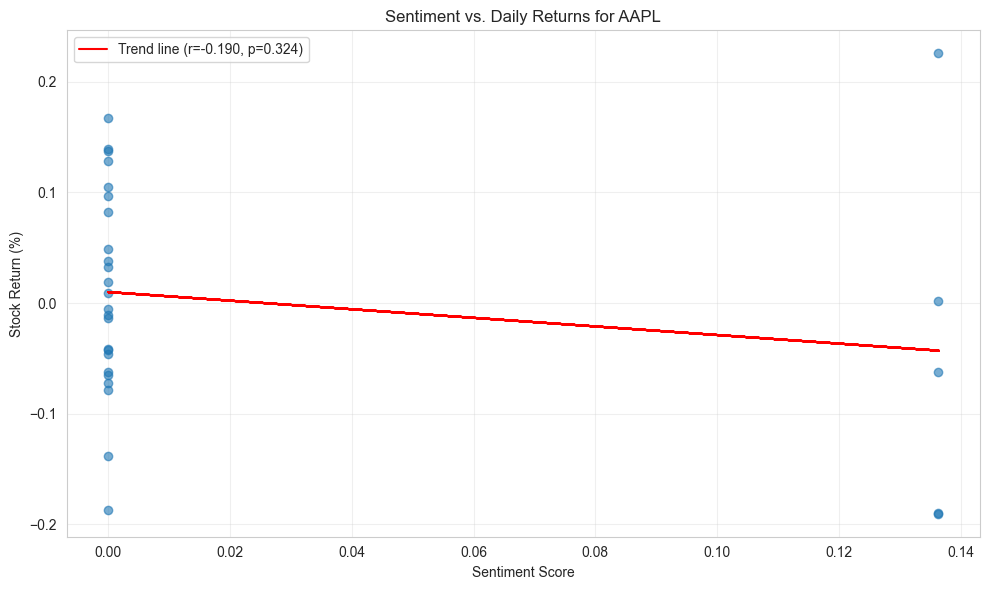

In [25]:
# Scatter plot of sentiment vs returns
plt.figure(figsize=(10, 6))
plot_sentiment_returns_scatter(merged_df, title=f'Sentiment vs. Daily Returns for {ticker}')
plt.show()

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

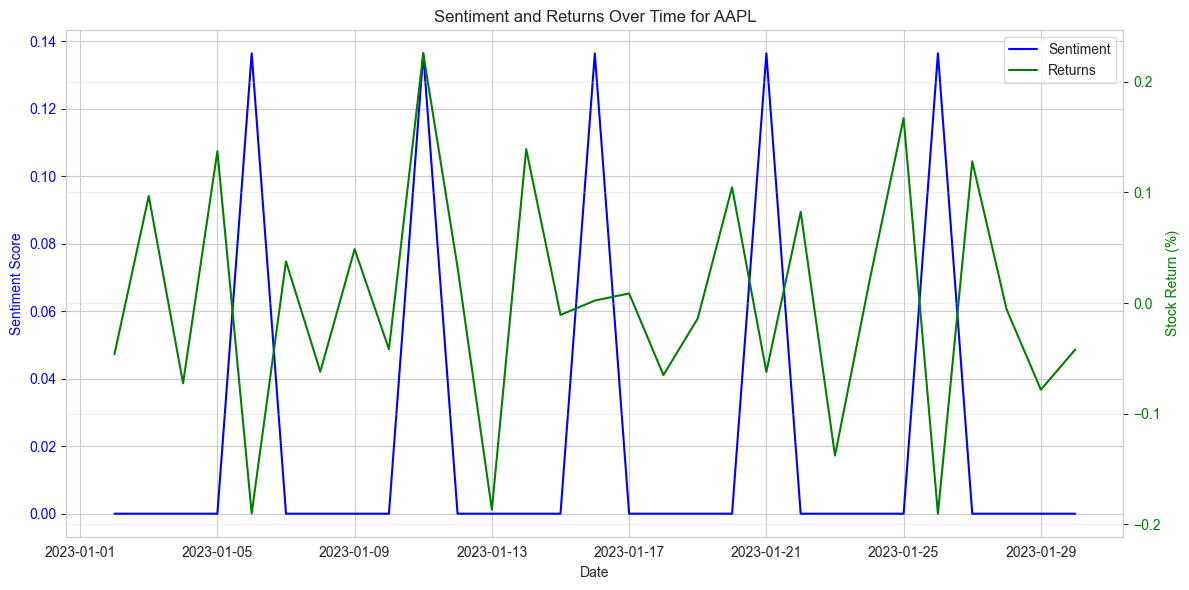

In [26]:
# Time series plot
plt.figure(figsize=(12, 6))
plot_sentiment_returns_time_series(merged_df, title=f'Sentiment and Returns Over Time for {ticker}')
plt.show()

<Figure size 1200x600 with 0 Axes>

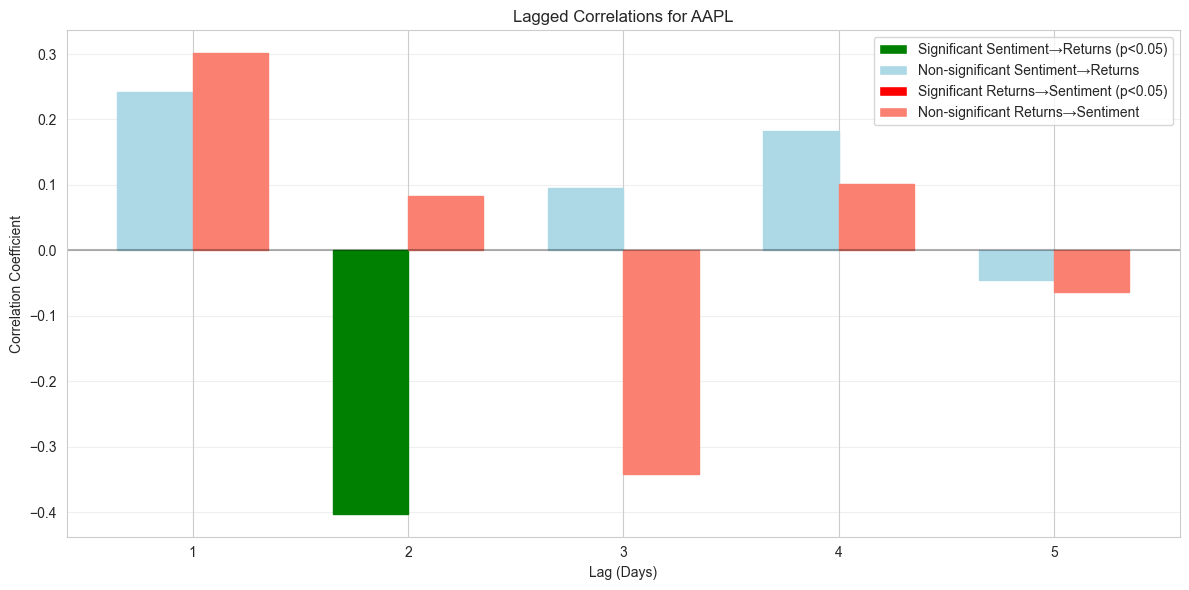

In [27]:
# Lagged correlations
plt.figure(figsize=(12, 6))
plot_lagged_correlations(correlation_results, title=f'Lagged Correlations for {ticker}')
plt.show()

## 9. Analysis of Multiple Stocks

Let's extend our analysis to multiple stocks and compare the results.

In [28]:
# Define function to analyze multiple stocks
def analyze_multiple_stocks(tickers):
    results = {}
    
    for ticker in tickers:
        stock_path = data_dir / f"{ticker}_historical_data.csv"
        
        if not os.path.exists(stock_path):
            print(f"Stock data file not found for {ticker}")
            continue
        
        try:
            # Load data
            news_df_tmp, stock_df_tmp = load_data(str(news_path), str(stock_path))
            
            # Filter news for this ticker if needed
            if 'stock' in news_df_tmp.columns:
                ticker_news = news_df_tmp[news_df_tmp['stock'] == ticker].copy()
                if len(ticker_news) == 0:
                    print(f"No news found for {ticker}")
                    continue
            else:
                ticker_news = news_df_tmp.copy()
            
            # Normalize dates
            ticker_news, stock_df_tmp = normalize_dates(ticker_news, stock_df_tmp, 'date', 'Date')
            
            # Analyze sentiment
            news_with_sentiment = analyze_sentiment(ticker_news, 'headline')
            
            # Calculate returns
            stock_with_returns = calculate_daily_returns(stock_df_tmp, 'Date', 'Close')
            
            # Aggregate daily sentiment
            daily_sentiment = aggregate_daily_sentiment(news_with_sentiment, 'date')
            
            # Merge sentiment with returns
            merged_df = merge_sentiment_with_returns(daily_sentiment, stock_with_returns, 'date', 'Date')
            
            # Calculate correlation
            correlation_results = calculate_correlation(merged_df)
            correlation_results['data'] = merged_df
            
            # Store results
            results[ticker] = correlation_results
            
            print(f"{ticker}: Correlation = {correlation_results['correlation']:.3f}, "
                 f"p-value = {correlation_results['p_value']:.3f}, "
                 f"significant = {correlation_results['significant']}")
            
        except Exception as e:
            print(f"Error analyzing {ticker}: {str(e)}")
    
    return results

# Analyze multiple stocks
print("Analyzing correlation for multiple stocks...\n")
stock_tickers = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA", "TSLA"]
multi_stock_results = analyze_multiple_stocks(stock_tickers)

Analyzing correlation for multiple stocks...

Stock data file not found for AAPL
Stock data file not found for AMZN
Stock data file not found for GOOG
Stock data file not found for META
Stock data file not found for MSFT
Stock data file not found for NVDA
Stock data file not found for TSLA


In [29]:
# Compare correlations across stocks
if multi_stock_results:
    # Extract correlation data
    tickers = list(multi_stock_results.keys())
    correlations = [multi_stock_results[ticker]['correlation'] for ticker in tickers]
    p_values = [multi_stock_results[ticker]['p_value'] for ticker in tickers]
    
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Ticker': tickers,
        'Correlation': correlations,
        'P-Value': p_values,
        'Significant': [p < 0.05 for p in p_values]
    })
    
    # Sort by correlation strength
    comparison_df = comparison_df.sort_values('Correlation', key=abs, ascending=False)
    
    print("Correlation comparison across stocks:")
    display(comparison_df)
    
    # Create bar chart
    plt.figure(figsize=(12, 6))
    colors = ['green' if p < 0.05 else 'gray' for p in comparison_df['P-Value']]
    
    plt.bar(comparison_df['Ticker'], comparison_df['Correlation'], color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Correlation between News Sentiment and Stock Returns')
    plt.xlabel('Stock Ticker')
    plt.ylabel('Pearson Correlation Coefficient')
    plt.grid(axis='y', alpha=0.3)
    
    # Add correlation values on top of bars
    for i, v in enumerate(comparison_df['Correlation']):
        plt.text(i, v + (0.01 if v >= 0 else -0.03), 
                f'{v:.3f}', 
                ha='center', va='bottom' if v >= 0 else 'top')
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='Statistically Significant (p<0.05)'),
        Patch(facecolor='gray', label='Not Significant')
    ]
    plt.legend(handles=legend_elements, loc='best')
    
    plt.show()
else:
    print("No results to compare.")

No results to compare.
